In [1]:
import numpy as np
# import tkinter
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller,kpss

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Load và tìm hiểu về dataset

In [2]:
df = pd.read_csv(r"C:\Users\Admin\Downloads\uber\uber_stock_data.csv")
df

,Date,Adj Close,Close,High,Low,Open,Volume
0,2019-05-10,41.570000,41.570000,45.000000,41.060001,42.000000,186322500
1,2019-05-13,37.099998,37.099998,39.240002,36.080002,38.790001,79442400
2,2019-05-14,39.959999,39.959999,39.959999,36.849998,38.310001,46661100
3,2019-05-15,41.290001,41.290001,41.880001,38.950001,39.369999,36086100
4,2019-05-16,43.000000,43.000000,44.060001,41.250000,41.480000,38115500
...,...,...,...,...,...,...,...
1439,2025-01-30,66.589996,66.589996,67.222000,63.419998,63.419998,33246500
1440,2025-01-31,66.849998,66.849998,67.870003,66.333000,67.089996,19805600
1441,2025-02-03,67.290001,67.290001,68.849998,65.178001,65.300003,25290000
1442,2025-02-04,69.750000,69.750000,70.190002,67.690002,67.690002,33786200


In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1444 non-null   datetime64[ns]
 1   Adj Close  1444 non-null   float64       
 2   Close      1444 non-null   float64       
 3   High       1444 non-null   float64       
 4   Low        1444 non-null   float64       
 5   Open       1444 non-null   float64       
 6   Volume     1444 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 79.1 KB


In [5]:
df.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,1444,1444.000000,1444.000000,1444.000000,1444.000000,1444.000000,1.444000e+03
mean,2022-03-22 02:49:31.745152256,44.465374,44.465374,45.287511,43.643301,44.493022,2.429800e+07
min,2019-05-10 00:00:00,14.820000,14.820000,17.799999,13.710000,15.960000,3.380000e+06
25%,2020-10-13 18:00:00,31.930000,31.930000,32.653749,31.181250,31.867499,1.498905e+07
50%,2022-03-21 12:00:00,41.355001,41.355001,41.910000,40.518499,41.215000,2.036965e+07
75%,2023-08-28 06:00:00,54.719999,54.719999,55.635001,53.597502,54.664999,2.843280e+07
max,2025-02-05 00:00:00,86.339996,86.339996,87.000000,84.180000,85.639999,3.642318e+08
std,NaN,15.594262,15.594262,15.740825,15.482652,15.643967,1.774084e+07


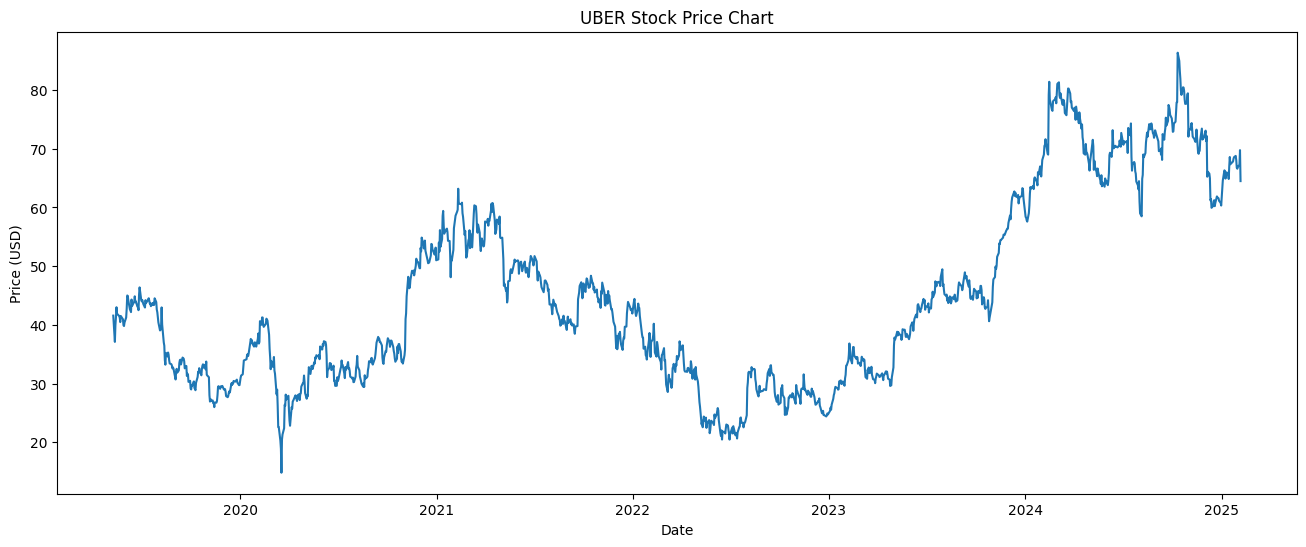

In [6]:
plt.figure(figsize=(16,6))  
plt.plot(df["Date"],df["Close"]) 
plt.title("UBER Stock Price Chart")  
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()  

### Nhận xét:
+ Năm 2020 và năm 2022 bị giảm so với các năm còn lại do các cáo buộc và dịch Covid

In [7]:
MA_per_year = df.groupby(pd.Grouper(key='Date',freq='YE')).mean()
MA_per_year

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2019-12-31,35.537669,35.537669,36.214110,34.888012,35.625730,1.879827e+07
2020-12-31,35.511660,35.511660,36.296320,34.633447,35.469802,2.767980e+07
2021-12-31,48.610040,48.610040,49.588691,47.700925,48.733790,2.335221e+07
2022-12-31,29.352032,29.352032,30.122422,28.632558,29.391096,3.000430e+07
2023-12-31,41.780120,41.780120,42.354860,41.082436,41.623816,2.450654e+07
2024-12-31,70.766826,70.766826,71.838321,69.770246,70.914567,1.920038e+07
2025-12-31,66.763043,66.763043,67.836826,65.730566,66.633261,2.774969e+07


### Giá đóng cửa và giá đóng cửa đều chỉnh bằng nhau cho thấy doanh nghiệp chưa có bước đi lớn ví dụ như chia cổ phiếu, tái thiết lập cấu trúc,...

<BarContainer object of 7 artists>

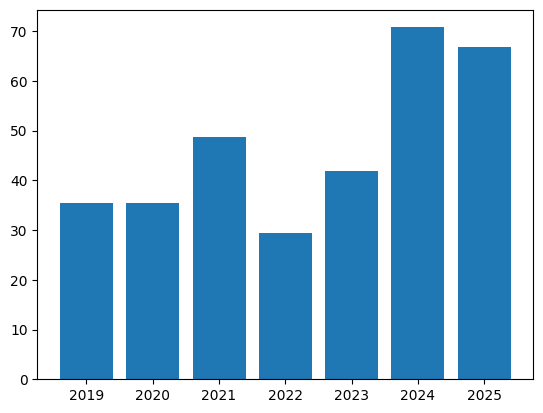

In [8]:
plt.bar(MA_per_year.index.year,height=MA_per_year['Adj Close'])

### Năm 2022 có dịch covid nên doanh nghiệp gặp khó khăn trong doanh thu.

Ngoài ra các năm còn lại đều có xu hướng tăng trưởng mạnh

In [9]:
df['Year'] = df['Date'].dt.year
df['DayOfYear'] = df['Date'].dt.dayofyear

2019
2020
2021
2022
2023
2024
2025


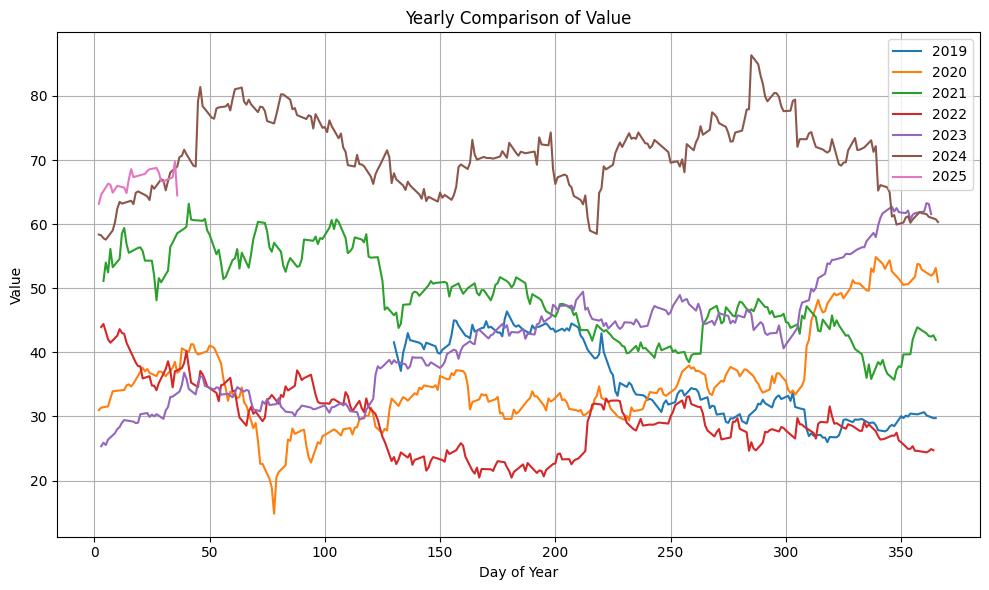

In [10]:
plt.figure(figsize=(10, 6))
for year, group in df.groupby('Year'):
    print(year)
    plt.plot(group['DayOfYear'], group['Adj Close'], label=str(year))
    
plt.xlabel('Day of Year')
plt.ylabel('Value')
plt.title('Yearly Comparison of Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Nhận xét:
+ Vào quý 1 mỗi năm đều có xu hướng tăng nhẹ
+ Giá trị tối đa trung bình mỗi năm đều đạt dưới 70 đô với trường hợp đặc biệt trong năm 2024.
+ Quý 2 và Q3 có khả năng giảm nhẹ hoặc mạnh tùy vào các yếu tố khách quan

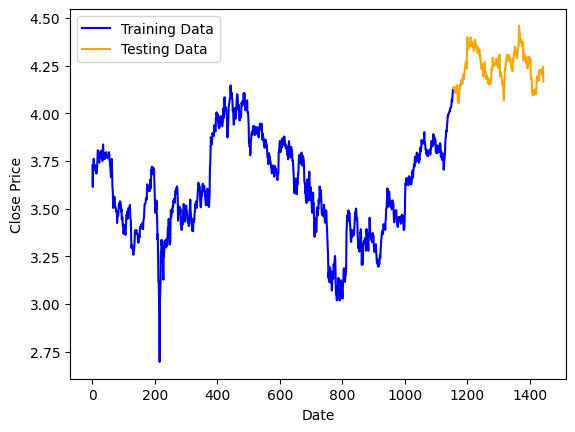

In [11]:
log_data = np.log(df['Close'])
train_data, test_data = log_data[:int(len(log_data)*0.8)], log_data[int(len(log_data)*0.8):]
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train_data,'blue', label='Training Data')
plt.plot(test_data,'orange', label='Testing Data')
plt.legend()

Text(0.5, 1.0, 'rolling mean and std')

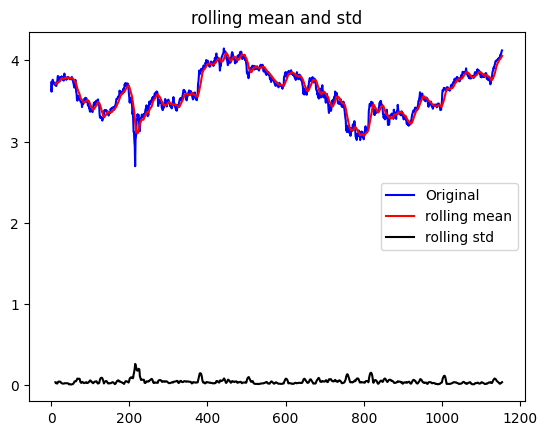

In [12]:
# phan ra du lieu chuoi thoi gian
# ve bieu do lich su so sanh gia dong cua cung voi gia ti trung binh va do lch chuan cua 12 ky truoc do 
rolmean=train_data.rolling(12).mean()
rolstd=train_data.rolling(12).std()
plt.plot(train_data,color='blue',label='Original')
plt.plot(rolmean,color='red',label='rolling mean')
plt.plot(rolstd,color='black',label='rolling std')
plt.legend()
plt.title('rolling mean and std')

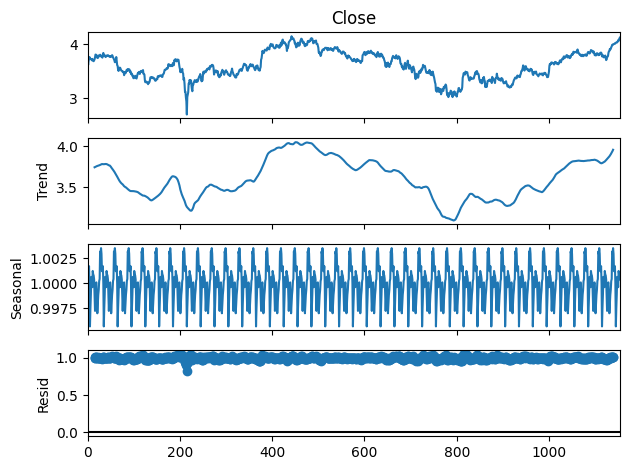

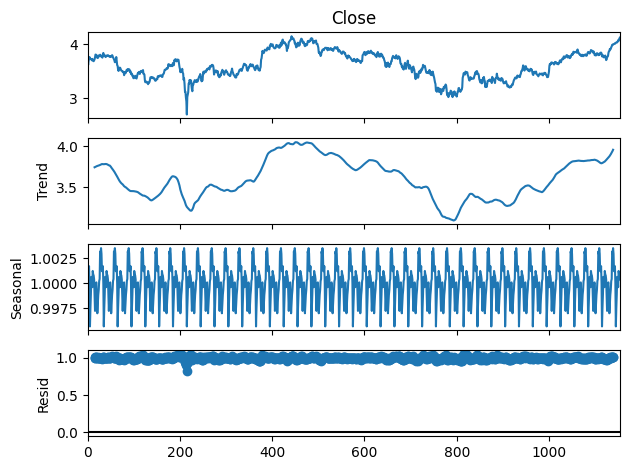

In [13]:
decompose_result=seasonal_decompose(train_data,model='multiplicative',period=30)
decompose_result.plot()

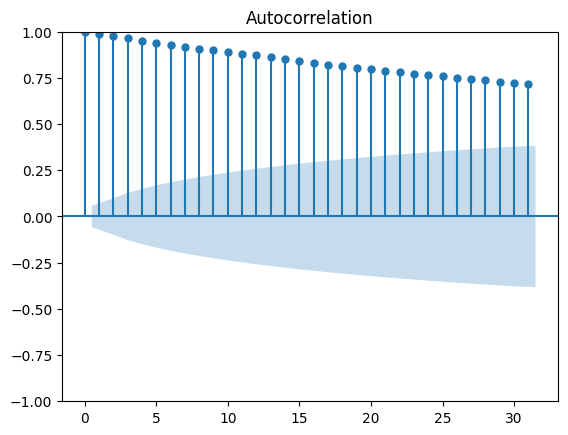

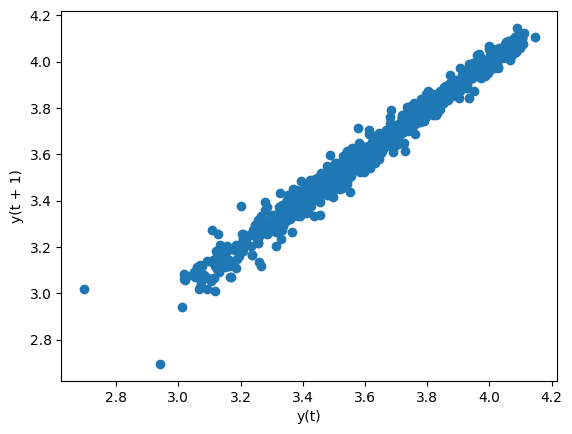

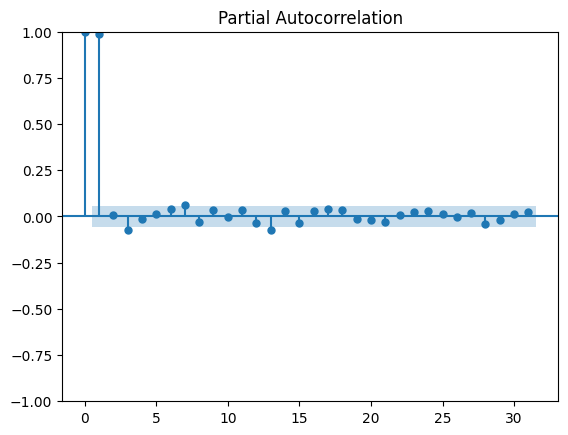

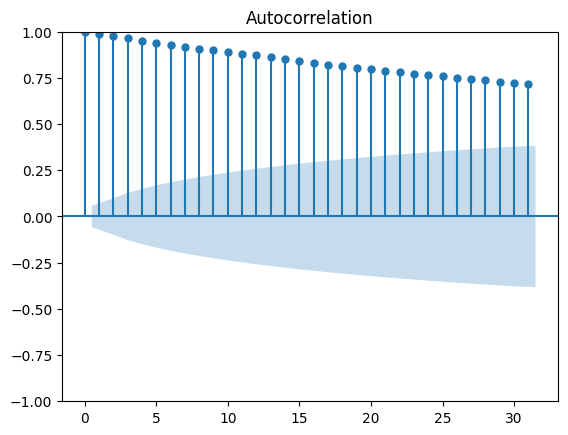

In [14]:
# kiem dinh tu tuong quan (auto correlation)
pd.plotting.lag_plot(train_data)
# pd.plotting.autocorrelation_plot(df['Close'])
plot_pacf(train_data)
plot_acf(train_data)

<Axes: title={'center': 'first-order difference'}>

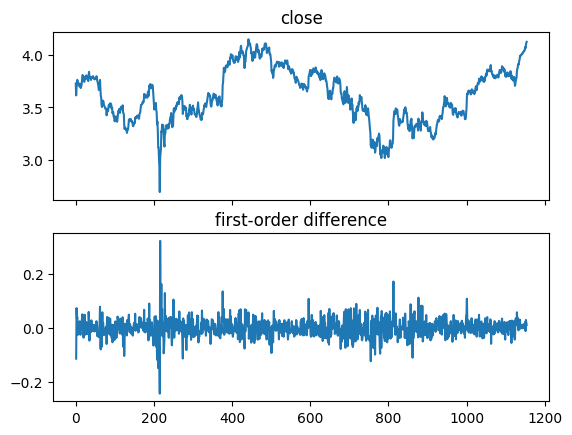

In [15]:
diff = train_data.diff(1).dropna()
# bieu do the hien du lieu ban dau va sau khi lay sai phan
fig,ax = plt.subplots(2,sharex='all')
train_data.plot(ax=ax[0],title='close')
diff.plot(ax=ax[1],title='first-order difference')

### Các giá trị sai số đều tập trung tại 0 -> data dạng tĩnh nên các model phù hợp dự đoán bao gồm: ARIMA, prohet,...

(-9.189397049932309, 2.1436067937361383e-15, 16, 1137, {'1%': -3.436114401808766, '5%': -2.8640853428381092, '10%': -2.568125207156112}, -4381.256061279479)
------------------------------
(0.11538096411542367, 0.1, 3, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\Admin\AppData\Local\Temp\ipykernel_28580\1287993251.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(kpss(diff))


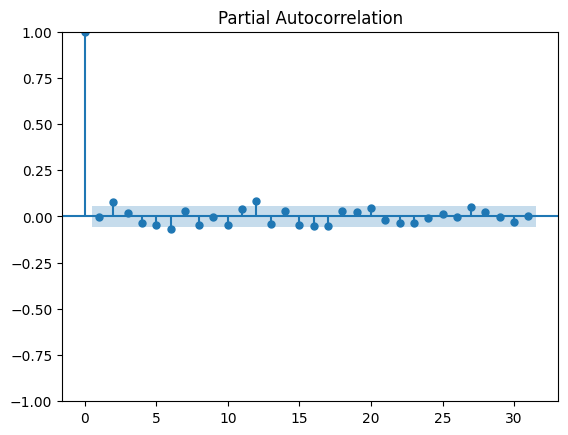

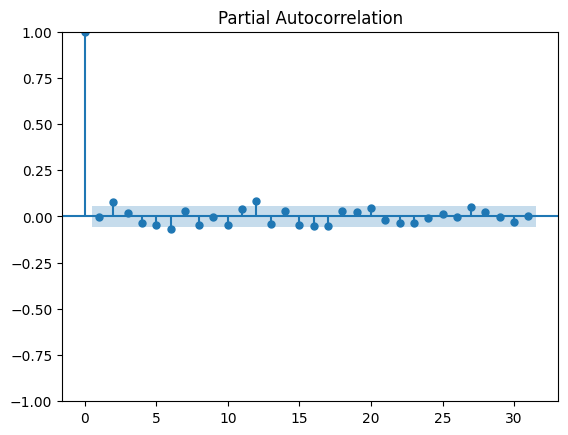

In [16]:
print(adfuller(diff))
print('------------------------------')
print(kpss(diff))
plot_pacf(diff) 

### Nhận xét:
+ Giá trị p rất nhỏ: 2.1436067937361383e-15
+ giá trị thống kê ADF là số âm: -9.189397049932309 

-> Ta có thể chắc chắn đây là data tĩnh

### Tìm tham số tối ưu cho ARIMA bằng cách sử dụng thư viện AUTOARIMA

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4462.651, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4457.980, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4456.011, Time=0.04 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4456.001, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4459.870, Time=0.03 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4459.820, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4459.425, Time=0.06 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4458.759, Time=0.33 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4458.655, Time=0.75 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4454.151, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4458.367, Time=0.20 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4457.874, Time=0.32 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-4457.925, Time=0.71 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-4464.593, Time=0.43 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-4462.359, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4461.616, Time=0.18 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-4466.879, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-4459.782, Time=0.17 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-4461.722, Time=0.60 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-4460.619, Time=0.57 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-4460.517, Time=0.41 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-4463.961, Time=0.46 sec


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,0,0)[0]             : AIC=-4458.104, Time=0.60 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 7.992 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1155
Model:               SARIMAX(3, 1, 2)   Log Likelihood                2239.439
Date:                Tue, 08 Apr 2025   AIC                          -4466.879
Time:                        00:03:01   BIC                          -4436.573
Sample:                             0   HQIC                         -4455.441
                               - 1155                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3926      0.076     18.246      0.000       1.243

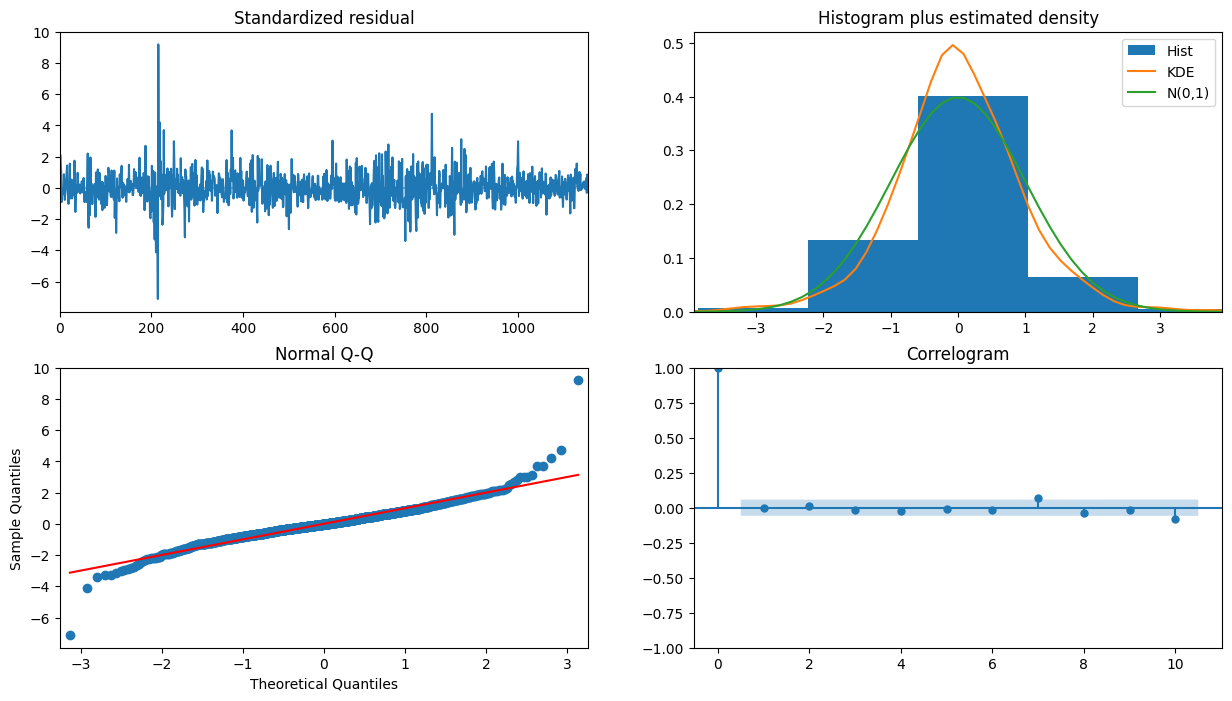

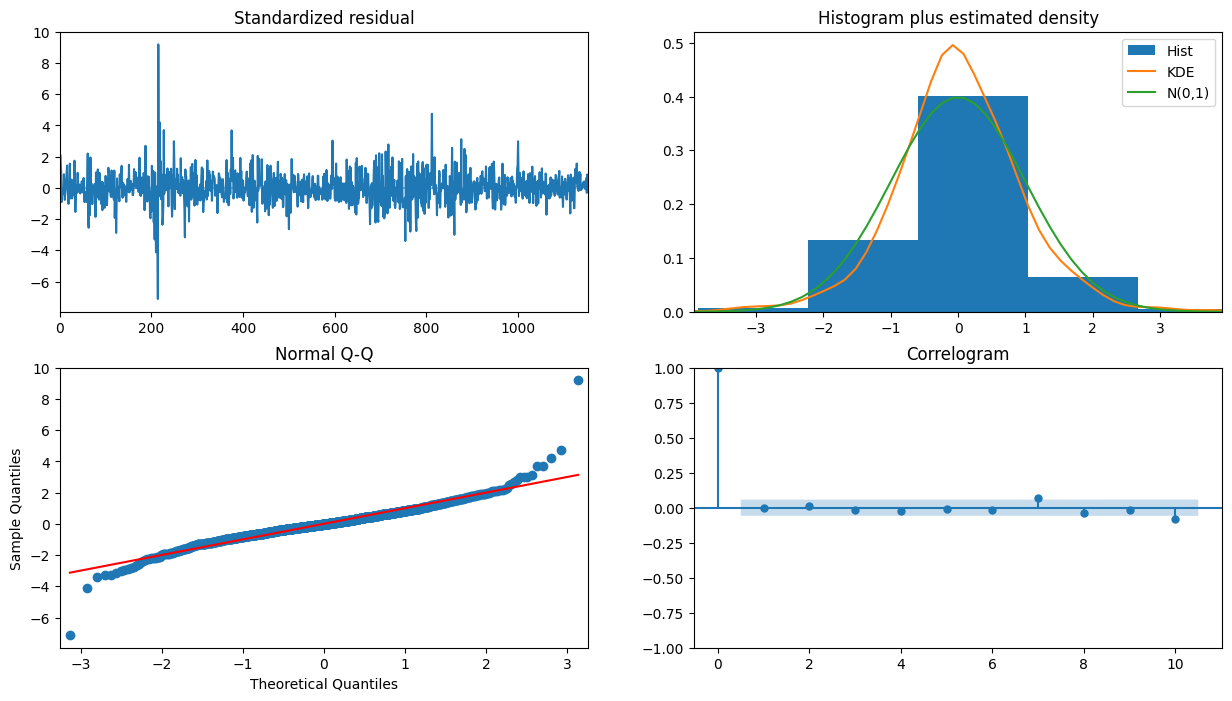

In [17]:
# xac dinh tham so p,d,q cho mo hinh Arima
stepwise_fit=auto_arima(train_data,trace=True,
                        suppress_warnings=True)
print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize=(15,8))

In [18]:
model = ARIMA(train_data, order=(3,1,2), trend='t')
fitted=model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1155
Model:                 ARIMA(3, 1, 2)   Log Likelihood                2236.923
Date:                Tue, 08 Apr 2025   AIC                          -4459.846
Time:                        00:03:03   BIC                          -4424.489
Sample:                             0   HQIC                         -4446.502
                               - 1155                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003      0.001      0.282      0.778      -0.002       0.003
ar.L1          0.8576      0.334      2.565      0.010       0.202       1.513
ar.L2         -0.3421      0.212     -1.611      0.1

In [19]:
fc = fitted.get_forecast(len(test_data))
fc_value = fc.predicted_mean
fc_value.index = test_data.index
conf = fc.conf_int(alpha=0.05)
lower_series = conf['lower Close']
lower_series.index = test_data.index
upper_series = conf['upper Close']
upper_series.index = test_data.index

In [20]:
mse= mean_squared_error(test_data,fc_value)
print('test MSE: %.3f' % mse)
rmse=np.sqrt(mse)
print('test RMSE: {:.3f}'.format(rmse))

test MSE: 0.013
test RMSE: 0.115


In [21]:
test_data

1155    4.134526
1156    4.138680
1157    4.126650
1158    4.135167
1159    4.124874
          ...   
1439    4.198554
1440    4.202451
1441    4.209012
1442    4.244917
1443    4.166355
Name: Close, Length: 289, dtype: float64

In [22]:
baseline_prediction = np.full_like(test_data, train_data.mean())
baseline_rmse=np.sqrt(mean_squared_error(test_data,baseline_prediction))

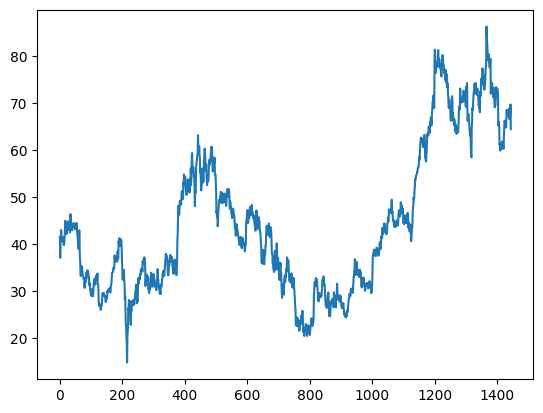

In [23]:
plt.plot(df['Adj Close'])

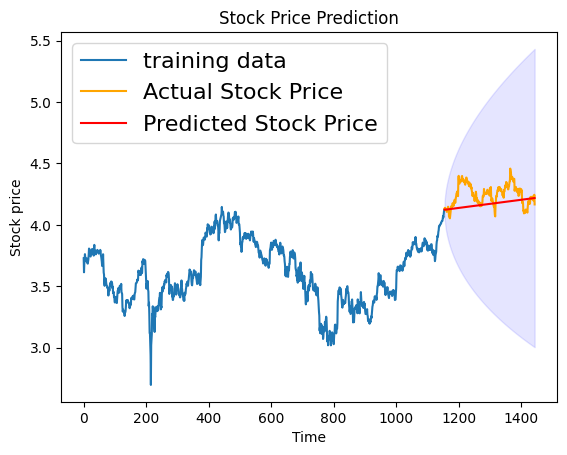

In [24]:
# plot actual vs predicted value
plt.plot(train_data,label='training data')
plt.plot(test_data,color='orange', label='Actual Stock Price')
plt.plot(fc_value, color='red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='b', alpha=.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend(loc='upper left',fontsize=16)
plt.show()

ARIMA model RMSE:{:.2f} 0.11507363463596046
baseline RMSE: {:.2F} 0.6429322980725347


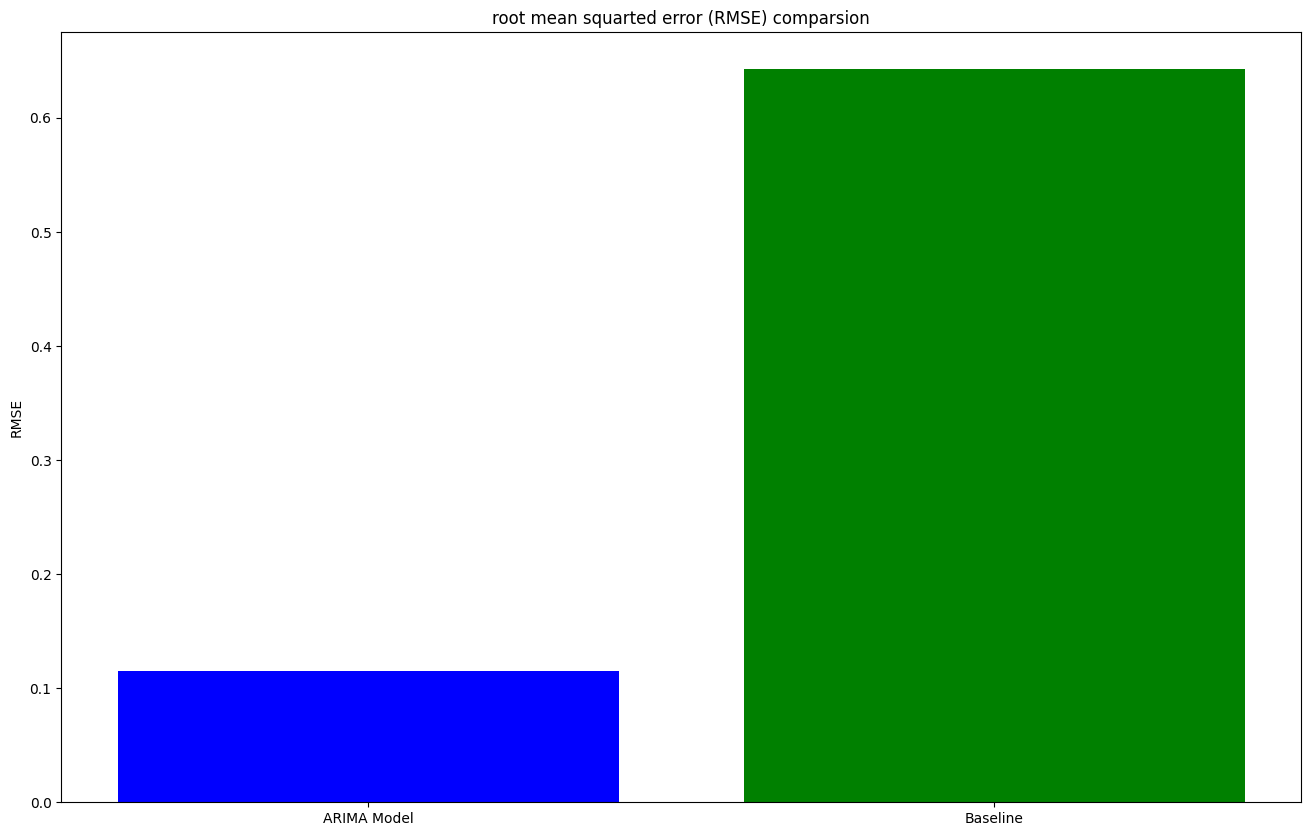

In [25]:
plt.figure(figsize=(16,10))
plt.bar(['ARIMA Model','Baseline'],[rmse,baseline_rmse],color=['blue','green'])
plt.title('root mean squarted error (RMSE) comparsion')
plt.ylabel('RMSE')
print("ARIMA model RMSE:{:.2f}",format(rmse))
print("baseline RMSE: {:.2F}",format(baseline_rmse))